In [59]:
import random
import imblearn
#import math
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, silhouette_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, to_graphviz

random_state = 1
random.seed(random_state)
#synthetic data https://www.kaggle.com/ntnu-testimon/paysim1

#data = pd.read_csv (r"C:\Users\ricka\Documents\synthetic_data.csv")
data = pd.read_csv (r"C:\Users\ricka\Documents\data\done\transactions_redone.csv")
#nodes = pd.read_csv (r"C:\Users\ricka\Documents\data\done\accounts_redone.csv")

In [60]:
#clean

y = data["is_sar"]*1
X = data.drop(["tx_type", "alert_id", "is_sar"], axis=1)
le = preprocessing.LabelEncoder()
X["tran_timestamp"] = le.fit_transform(X["tran_timestamp"].astype("str"))
"""
X = data.loc[(data.type == 'TRANSFER') | (data.type == 'CASH_OUT')]
y = X['isFraud']
del X['isFraud']
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)
"""
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.4, random_state=random_state)
Xtest, Xpre, ytest, ypre = train_test_split(Xtest, ytest, test_size=0.5, random_state=random_state)

In [37]:
#remove transactions
"""
dtrain = xgb.DMatrix(X, label=y)
param_dist = {"eta": 1, "max_depth": 5, "booster": "gbtree", "validate_parameters": True}
clf = xgb.XGBClassifier(**param_dist)
model = clf.fit(Xpre, ypre, eval_set=[(Xpre, ypre), (Xtrain, ytrain)],
        eval_metric='logloss', verbose=True)
prob = model.predict_proba(Xtrain)
#ypred = model.predict(Xtest)
ypred = (prob[:,1] >= 0.01).astype(bool) #use new threshold
confusion_matrix(ytrain, ypred)

#remove transactions
#alpha = [0.09, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999]
alpha = [0.9, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
num_samples = np.zeros(len(alpha))
for i in range(len(alpha)):
    #num_samples[i] = len(prob[prob[:,0] < alpha[i]])
    num_samples[i] = len(prob[prob[:,1] > alpha[i]])

plt.xscale('logit')
plt.plot(alpha, num_samples)
plt.xlabel("Threshold")
plt.ylabel("Transactions kept")
plt.show()

ind = [i for i in range(len(prob)) if prob[i,1] > 0.0000001] #10^-7 for now
Xtrain = Xtrain.iloc[ind]
ytrain = ytrain.iloc[ind]
"""

'\ndtrain = xgb.DMatrix(X, label=y)\nparam_dist = {"eta": 1, "max_depth": 5, "booster": "gbtree", "validate_parameters": True}\nclf = xgb.XGBClassifier(**param_dist)\nmodel = clf.fit(Xpre, ypre, eval_set=[(Xpre, ypre), (Xtrain, ytrain)],\n        eval_metric=\'logloss\', verbose=True)\nprob = model.predict_proba(Xtrain)\n#ypred = model.predict(Xtest)\nypred = (prob[:,1] >= 0.01).astype(bool) #use new threshold\nconfusion_matrix(ytrain, ypred)\n\n#remove transactions\n#alpha = [0.09, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999]\nalpha = [0.9, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]\nnum_samples = np.zeros(len(alpha))\nfor i in range(len(alpha)):\n    #num_samples[i] = len(prob[prob[:,0] < alpha[i]])\n    num_samples[i] = len(prob[prob[:,1] > alpha[i]])\n\nplt.xscale(\'logit\')\nplt.plot(alpha, num_samples)\nplt.xlabel("Threshold")\nplt.ylabel("Transactions kept")\nplt.show()\n\nind = [i for i in range(len(prob)) if prob[i,1] > 0.0000001] #10^-7 for now\nXtrain

In [38]:
#SMOTE (oversampling)
"""
sm = SMOTE(random_state=random_state)
Xtrain, ytrain = sm.fit_resample(Xtrain, ytrain)

#undersampling
undersample = RandomUnderSampler(sampling_strategy=0.5)
Xtrain, ytrain = undersample.fit_resample(Xtrain, ytrain)

print(ytrain.value_counts().to_frame())
print(len(Xtrain))
"""

'\nsm = SMOTE(random_state=random_state)\nXtrain, ytrain = sm.fit_resample(Xtrain, ytrain)\n\n#undersampling\nundersample = RandomUnderSampler(sampling_strategy=0.5)\nXtrain, ytrain = undersample.fit_resample(Xtrain, ytrain)\n\nprint(ytrain.value_counts().to_frame())\nprint(len(Xtrain))\n'

In [61]:
dtrain = xgb.DMatrix(X, label=y)
param_dist = {"eta": 1, "max_depth": 7, "booster": "gbtree", "validate_parameters": True}
clf = xgb.XGBClassifier(**param_dist)

model = clf.fit(Xtrain, ytrain, eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
            eval_metric='logloss', verbose=False)
prob = model.predict_proba(Xtest)
        #ypred = model.predict(Xtest)

ypred = (prob[:,1] >= 0.01).astype(bool) #use new threshold
cm = confusion_matrix(ytest, ypred)
fp = cm[0, 1]
fn = cm[1, 0]
aps = average_precision_score(ytest, ypred)
recall = recall_score(ytest, ypred)
precision = precision_score(ytest, ypred)

C:\Users\ricka\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [66]:
ytest.value_counts().to_frame()

,is_sar
0,177010
1,139


In [39]:
eta = [0.1, 0.25, 0.4, 0.55, 0.70, 0.85, 1, 1.15, 1.3, 1.45, 1.6, 1.75, 1.9, 2.05]
depth = [3, 4, 5, 6, 7]
fp = np.zeros((14, 5))
fn = np.zeros((14, 5))
aps = np.zeros((14, 5))
recall = np.zeros((14, 5))
precision = np.zeros((14, 5))

for j in range(len(depth)):
    for i in range(len(eta)):
        dtrain = xgb.DMatrix(X, label=y)
        param_dist = {"eta": eta[i], "max_depth": depth[j], "booster": "gbtree", "validate_parameters": True}
        clf = xgb.XGBClassifier(**param_dist)

        model = clf.fit(Xtrain, ytrain, eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
                eval_metric='logloss', verbose=False)
        prob = model.predict_proba(Xtest)
        #ypred = model.predict(Xtest)

        ypred = (prob[:,1] >= 0.01).astype(bool) #use new threshold
        cm = confusion_matrix(ytest, ypred)
        fp[i, j] = cm[0, 1]
        fn[i, j] = cm[1, 0]
        aps[i, j] = average_precision_score(ytest, ypred)
        recall[i, j] = recall_score(ytest, ypred)
        precision[i, j] = precision_score(ytest, ypred)
        print(i)
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
4


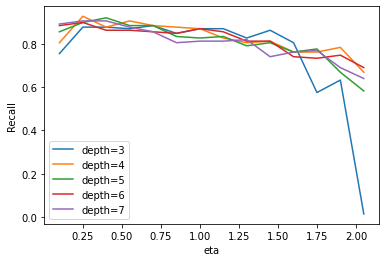

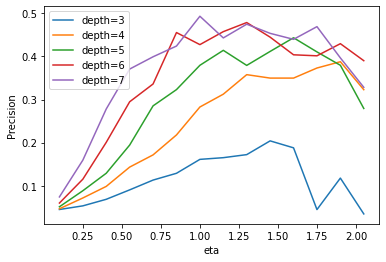

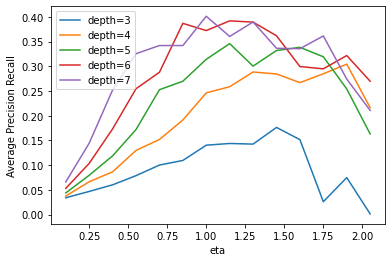

In [40]:
for i in range(5):
    plt.plot(eta, recall[:,i])
plt.legend(["depth=3", "depth=4", "depth=5", "depth=6", "depth=7"])
plt.xlabel("eta")
plt.ylabel("Recall")
plt.show()

for i in range(5):
    plt.plot(eta, precision[:,i])
plt.legend(["depth=3", "depth=4", "depth=5", "depth=6", "depth=7"])
plt.xlabel("eta")
plt.ylabel("Precision")
plt.show()

for i in range(5):
    plt.plot(eta, aps[:,i])
plt.legend(["depth=3", "depth=4", "depth=5", "depth=6", "depth=7"])
plt.xlabel("eta")
plt.ylabel("Average Precision Recall")
plt.show()

In [48]:
data = pd.read_csv (r"C:\Users\ricka\Documents\synthetic_data.csv")

X = data.loc[(data.type == 'TRANSFER') | (data.type == 'CASH_OUT')]
y = X['isFraud']
del X['isFraud']
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

eta = [0.1, 0.25, 0.4, 0.55, 0.70, 0.85, 1, 1.15, 1.3, 1.45, 1.6, 1.75, 1.9, 2.05]
depth = [3, 4, 5, 6, 7]
fp = np.zeros((14, 5))
fn = np.zeros((14, 5))
aps = np.zeros((14, 5))
recall = np.zeros((14, 5))
precision = np.zeros((14, 5))

for j in range(len(depth)):
    for i in range(len(eta)):
        dtrain = xgb.DMatrix(X, label=y)
        param_dist = {"eta": eta[i], "max_depth": depth[j], "booster": "gbtree", "validate_parameters": True}
        clf = xgb.XGBClassifier(**param_dist)

        model = clf.fit(Xtrain, ytrain, eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
                eval_metric='logloss', verbose=False)
        prob = model.predict_proba(Xtest)
        #ypred = model.predict(Xtest)

        ypred = (prob[:,1] >= 0.01).astype(bool) #use new threshold
        cm = confusion_matrix(ytest, ypred)
        fp[i, j] = cm[0, 1]
        fn[i, j] = cm[1, 0]
        aps[i, j] = average_precision_score(ytest, ypred)
        recall[i, j] = recall_score(ytest, ypred)
        precision[i, j] = precision_score(ytest, ypred)
        print(i)

C:\Users\ricka\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13


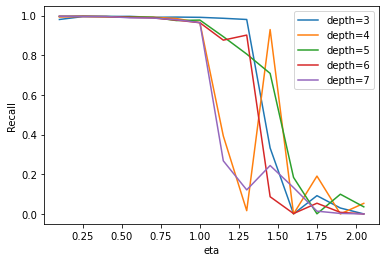

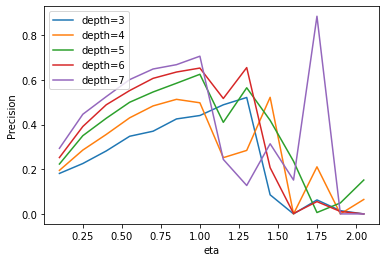

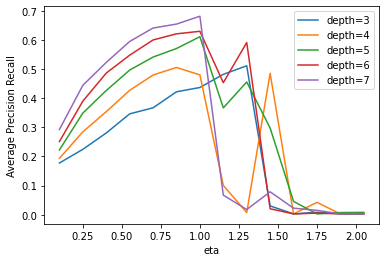

In [49]:
for i in range(5):
    plt.plot(eta, recall[:,i])
plt.legend(["depth=3", "depth=4", "depth=5", "depth=6", "depth=7"])
plt.xlabel("eta")
plt.ylabel("Recall")
plt.show()

for i in range(5):
    plt.plot(eta, precision[:,i])
plt.legend(["depth=3", "depth=4", "depth=5", "depth=6", "depth=7"])
plt.xlabel("eta")
plt.ylabel("Precision")
plt.show()

for i in range(5):
    plt.plot(eta, aps[:,i])
plt.legend(["depth=3", "depth=4", "depth=5", "depth=6", "depth=7"])
plt.xlabel("eta")
plt.ylabel("Average Precision Recall")
plt.show()

In [56]:
#from sklearn.metrics import accuracy_score
#accuracy_score(ytest, ypred)
#fn[6,4]
#ytest.value_counts().to_frame()

,isFraud
0,552431
1,1651
